# Understanding Word Embeddings to Recommend Movies

**Word Embedding** is a technique with which the distance and the relationship between categorical data or words can be determined by representing them as numerical vectors in a n-dimensional space. The distance between the words is proportional to the similarity between them depending on the context of the problem. This technique is highly used in Natural Language Processing and pretrained models like <a href="https://en.wikipedia.org/wiki/Word2vec">Word2Vec</a> and <a href="https://en.wikipedia.org/wiki/GloVe_(machine_learning)">GloVe</a> were developed based on it. 

Word Embeddings can also be created by training them on the corpus of documents or text in specific supervised learning problems using a neural network embedding model. In this project, word embeddings are created by training movie plots against its corresponding movie genres. 

*Wouldn't it be interesting to find similar words with respect to genres. For example, words like relationship, marriage, divorce, wedding will be closer or neighbors to each other in an n-dimensional space, as the movie plots will be trained with it's corresponding genre "Romance".* You can take a step further and use word embeddings to provide movie recommendations. The detailed steps on the approaches and the process is explained below using the IMDB Movies dataset.

## Steps Involved

>1) Data loading and exploration<br>
>2) Data Cleaning<br>
>3) Data Preparation for training<br>
>4) Building and training the Neural Network model architecture<br>
>5) Model evaluation<br>
>6) Analysing the Word Embeddings<br>
>7) Recommend movies using the trained Word Embeddings <br>

### Importing Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt 
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, accuracy_score
import spacy
nlp = spacy.load("en_core_web_sm")
import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Embedding, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process 
from difflib import SequenceMatcher
import math
from wordcloud import WordCloud, STOPWORDS 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aashe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading the data

In [3]:
df_original = pd.read_csv("movies.csv")
df_original.head()

,movie_id,title,plot,movie_rating,movie_rating.1,metacritic,dvd_release,production,actors,movie_votes,director,release_date,runtime,genre,awards,keywords,Unnamed: 16
0,tt0010323,The Cabinet of Dr. Caligari,"Hypnotist Dr. Caligari uses a somnambulist, Ce...",UNRATED,8.1,NaN,15-Oct-97,Rialto Pictures,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...","42,583",Robert Wiene,19-Mar-21,67 min,"Fantasy, Horror, Mystery",1 nomination.,expressionism|somnambulist|avant-garde|hypnosi...,NaN
1,tt0052893,Hiroshima Mon Amour,A French actress filming an anti-war film in H...,NOT RATED,8.0,NaN,24-Jun-03,Rialto Pictures,"Emmanuelle Riva, Eiji Okada, Stella Dassas, Pi...","21,154",Alain Resnais,16-May-60,90 min,"Drama, Romance",Nominated for 1 Oscar. Another 6 wins & 5 nomi...,memory|atomic-bomb|lovers-separation|impossibl...,NaN
2,tt0058898,Alphaville,A U.S. secret agent is sent to the distant spa...,NOT RATED,7.2,NaN,20-Oct-98,Rialto Pictures,"Eddie Constantine, Anna Karina, Akim Tamiroff","17,801",Jean-Luc Godard,5-May-65,99 min,"Drama, Mystery, Sci-Fi",1 win.,dystopia|french-new-wave|satire|comic-violence...,NaN
3,tt0074252,"Ugly, Dirty and Bad",Four generations of a family live crowded toge...,NaN,7.9,NaN,1-Nov-16,Compagnia Cinematografica Champion,"Nino Manfredi, Maria Luisa Santella, Francesco...","5,705",Ettore Scola,23-Sep-76,115 min,"Comedy, Drama",1 win & 2 nominations.,incest|failed-murder-attempt|poisoned-food|bap...,NaN
4,tt0084269,Losing Ground,A comedy-drama about a Black American female p...,NaN,6.3,NaN,NaN,Milestone Film & Video,"Billie Allen, Gary Bolling, Clarence Branch Jr...",132,Kathleen Collins,1-Jun-82,86 min,"Comedy, Drama",NaN,artist|painter|marriage|black-independent-film...,NaN


In [4]:
df_original.shape

(8561, 17)

In [5]:
df_original.columns

Index(['movie_id', 'title', 'plot', 'movie_rating', 'movie_rating.1',
       'metacritic', 'dvd_release', 'production', 'actors', 'movie_votes',
       'director', 'release_date', 'runtime', 'genre', 'awards', 'keywords',
       'Unnamed: 16'],
      dtype='object')

<div class="alert alert-block alert-success">
The dataset has 8561 movies with 17 features.<br>
Features movie_id, title, plot, actors and genre are the only features that will be required for this project
</div>

### Null Values check and subsetting required features

In [6]:
df = df_original[['movie_id','title','plot','genre','actors']]
pd.DataFrame(df.isna().sum(),columns = ['Count of Nulls'])

,Count of Nulls
movie_id,93
title,93
plot,365
genre,137
actors,408


<div class="alert alert-block alert-warning">
These Null records need to be removed

### Dropping Null Values

In [7]:
df = df.dropna()
df['genre'] = df['genre'].astype('str')  ### Object to String Conversion
df['plot'] = df['plot'].astype('str')    ### Object to String Conversion
df.head()

,movie_id,title,plot,genre,actors
0,tt0010323,The Cabinet of Dr. Caligari,"Hypnotist Dr. Caligari uses a somnambulist, Ce...","Fantasy, Horror, Mystery","Werner Krauss, Conrad Veidt, Friedrich Feher, ..."
1,tt0052893,Hiroshima Mon Amour,A French actress filming an anti-war film in H...,"Drama, Romance","Emmanuelle Riva, Eiji Okada, Stella Dassas, Pi..."
2,tt0058898,Alphaville,A U.S. secret agent is sent to the distant spa...,"Drama, Mystery, Sci-Fi","Eddie Constantine, Anna Karina, Akim Tamiroff"
3,tt0074252,"Ugly, Dirty and Bad",Four generations of a family live crowded toge...,"Comedy, Drama","Nino Manfredi, Maria Luisa Santella, Francesco..."
4,tt0084269,Losing Ground,A comedy-drama about a Black American female p...,"Comedy, Drama","Billie Allen, Gary Bolling, Clarence Branch Jr..."


<div class="alert alert-block alert-warning">
As each movie has multiple genres, we will need to treat this as a multi-label classification problem during the training process 
</div>

### Frequency of observations across genres

A separate dataset was created by unpivoting the original data so that each movie has a record for each of its genres. In this way, frequency of genres across the whole data can be determined. <br><br><i> <u>Note:</u> This dataset was created just to understand the frequecy distrubution and wouldn't be used any further </i>

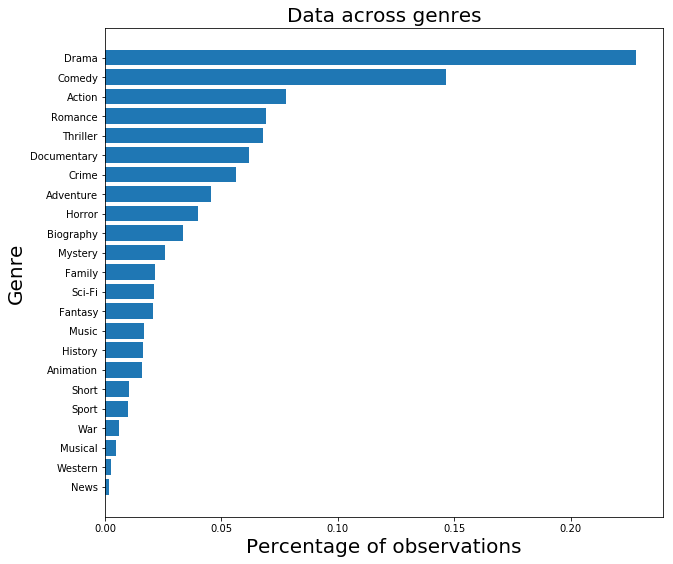

In [8]:
### Creating a dataframe to count the occurences of the genres
df_count_genre = df.copy()
df_count_genre['genres_list'] = df_count_genre['genre'].apply(lambda x: x.split(', '))
df_count_genre = df_count_genre.genres_list.apply(pd.Series).merge(df_count_genre, right_index=True,left_index=True).drop(["genre","genres_list"], axis = 1)
df_count_genre = df_count_genre.melt(id_vars = ['movie_id', 'title','plot','actors'], value_name = "genre")   ###Unpivot
df_count_genre = df_count_genre.sort_values(by = 'movie_id')
df_count_genre = df_count_genre.dropna()

###Plotting the genre distribution
genre_distribution = pd.DataFrame(df_count_genre.genre.value_counts(normalize = True)).sort_values(by=['genre'])
plt.figure(figsize=(10,9))
plt.barh(y=genre_distribution.index, width=genre_distribution['genre'],align='center')
plt.xlabel("Percentage of observations",fontsize=20)
plt.ylabel("Genre",fontsize=20)
plt.title("Data across genres",fontsize=20)
plt.show()

<div class="alert alert-block alert-warning">
From the plot, it is understood that the data is highly imbalanaced and this is a challenge during the training process

### Replacing the rarely occuring genres with "Others" category

In [9]:
#### News, Western, War, Sport, Short
df.genre.replace({"News": 'Others'},regex = True,inplace=True)
df.genre.replace({"Western": 'Others'},regex = True,inplace=True)
df.genre.replace({"War": 'Others'},regex = True,inplace=True)
df.genre.replace({"Sport": 'Others'},regex = True,inplace=True)
df.genre.replace({"Short": 'Others'},regex = True,inplace=True)
df.genre.replace({"Musical": 'Music'},regex = True,inplace=True)

### Converting the genres into list

In [10]:
df['genres_list'] = df['genre'].apply(lambda x: x.split(', '))
df.head()

,movie_id,title,plot,genre,actors,genres_list
0,tt0010323,The Cabinet of Dr. Caligari,"Hypnotist Dr. Caligari uses a somnambulist, Ce...","Fantasy, Horror, Mystery","Werner Krauss, Conrad Veidt, Friedrich Feher, ...","[Fantasy, Horror, Mystery]"
1,tt0052893,Hiroshima Mon Amour,A French actress filming an anti-war film in H...,"Drama, Romance","Emmanuelle Riva, Eiji Okada, Stella Dassas, Pi...","[Drama, Romance]"
2,tt0058898,Alphaville,A U.S. secret agent is sent to the distant spa...,"Drama, Mystery, Sci-Fi","Eddie Constantine, Anna Karina, Akim Tamiroff","[Drama, Mystery, Sci-Fi]"
3,tt0074252,"Ugly, Dirty and Bad",Four generations of a family live crowded toge...,"Comedy, Drama","Nino Manfredi, Maria Luisa Santella, Francesco...","[Comedy, Drama]"
4,tt0084269,Losing Ground,A comedy-drama about a Black American female p...,"Comedy, Drama","Billie Allen, Gary Bolling, Clarence Branch Jr...","[Comedy, Drama]"


### Movie Plot Cleaning

Word Embeddings will be created using the **Movie plots** and hence needs to be cleaned. The cleaning process involves<br>
- Stopwords removal
- Punctuations removal
- Lemmatization - Finding the root words for each word. This will reduce the overall vocabulary size.


In [12]:
def cleaning(word):
    
    ###Stopword Removal
    stop = stopwords.words('english')
    word = word.split()
    cleaned = " ".join([item for item in word if item.lower() not in stop])
    cleaned = cleaned.replace("'", "").lower()
    cleaned=re.sub(r'[^\w\s]',' ',cleaned)   ###Punctuation removal
    
    ###Lemmatization
    nlp_lemma = nlp(cleaned)
    cleaned = " ".join([item.lemma_ for item in nlp_lemma])
    
    return cleaned

### Extracting nouns and adjectives from the movie plots

In my opinion, nouns and adjectives of the movie plots are going to be the major part of speeches that will help in understanding the genres.

For example, a movie plot having words such as ghost, fear, zombie, vampire will mostly have "horror" as one of its genres.
Spacy library's **POS tagging** is used here to perform this action

In [13]:
def clean_pos(plot):
    plot = nlp(plot)
    tags = [i for i in plot if i.tag_ == 'NN' or i.tag_ == 'NNS' or i.tag_ == 'JJ' or i.tag_ == 'JJR' or i.tag_ == 'JJS']
    return tags

### Applying the above functions on the data

In [16]:
df['plot_cleaned']=df['plot'].apply(cleaning)
df.head()

,movie_id,title,plot,genre,actors,genres_list,plot_cleaned,plot_tags
0,tt0010323,The Cabinet of Dr. Caligari,"Hypnotist Dr. Caligari uses a somnambulist, Ce...","Fantasy, Horror, Mystery","Werner Krauss, Conrad Veidt, Friedrich Feher, ...","[Fantasy, Horror, Mystery]",hypnotist dr caligari use somnambulist ces...,"[caligari, use, somnambulist, cesare, commit, ..."
1,tt0052893,Hiroshima Mon Amour,A French actress filming an anti-war film in H...,"Drama, Romance","Emmanuelle Riva, Eiji Okada, Stella Dassas, Pi...","[Drama, Romance]",french actress film anti war film hiroshima af...,"[french, film, marry, japanese, architect, sha..."
2,tt0058898,Alphaville,A U.S. secret agent is sent to the distant spa...,"Drama, Mystery, Sci-Fi","Eddie Constantine, Anna Karina, Akim Tamiroff","[Drama, Mystery, Sci-Fi]",u s secret agent send distant space city alp...,"[secret, agent, distant, city, person, free, t..."
3,tt0074252,"Ugly, Dirty and Bad",Four generations of a family live crowded toge...,"Comedy, Drama","Nino Manfredi, Maria Luisa Santella, Francesco...","[Comedy, Drama]",four generation family live crowd together car...,"[generation, family, crowd, inner, city, plan,..."
4,tt0084269,Losing Ground,A comedy-drama about a Black American female p...,"Comedy, Drama","Billie Allen, Gary Bolling, Clarence Branch Jr...","[Comedy, Drama]",comedy drama black american female philosophy ...,"[drama, female, philosophy, professor, insensi..."


In [17]:
df['plot_tags']=df['plot_cleaned'].apply(clean_pos)
df.head()

,movie_id,title,plot,genre,actors,genres_list,plot_cleaned,plot_tags
0,tt0010323,The Cabinet of Dr. Caligari,"Hypnotist Dr. Caligari uses a somnambulist, Ce...","Fantasy, Horror, Mystery","Werner Krauss, Conrad Veidt, Friedrich Feher, ...","[Fantasy, Horror, Mystery]",hypnotist dr caligari use somnambulist ces...,"[caligari, use, somnambulist, cesare, commit, ..."
1,tt0052893,Hiroshima Mon Amour,A French actress filming an anti-war film in H...,"Drama, Romance","Emmanuelle Riva, Eiji Okada, Stella Dassas, Pi...","[Drama, Romance]",french actress film anti war film hiroshima af...,"[french, film, marry, japanese, architect, sha..."
2,tt0058898,Alphaville,A U.S. secret agent is sent to the distant spa...,"Drama, Mystery, Sci-Fi","Eddie Constantine, Anna Karina, Akim Tamiroff","[Drama, Mystery, Sci-Fi]",u s secret agent send distant space city alp...,"[secret, agent, distant, city, person, free, t..."
3,tt0074252,"Ugly, Dirty and Bad",Four generations of a family live crowded toge...,"Comedy, Drama","Nino Manfredi, Maria Luisa Santella, Francesco...","[Comedy, Drama]",four generation family live crowd together car...,"[generation, family, crowd, inner, city, plan,..."
4,tt0084269,Losing Ground,A comedy-drama about a Black American female p...,"Comedy, Drama","Billie Allen, Gary Bolling, Clarence Branch Jr...","[Comedy, Drama]",comedy drama black american female philosophy ...,"[drama, female, philosophy, professor, insensi..."


### Calculated the extracted POS tags length for each observation

In [18]:
df['plot_tags_length']  = df['plot_tags'].apply(lambda x: len(x))

### Outlier Detection

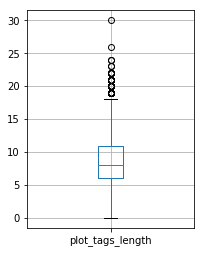

In [19]:
plt.figure(figsize=(3,4))
df.boxplot(column = ['plot_tags_length'])
plt.show()

<div class="alert alert-block alert-warning">
There are records where the plot POS tags length are way higher than the average plot tag length. These records are outliers and need to be treated. <b>Interquartile Range</b> method is used here to remove these outliers.
</div>

In [20]:
outlier_value = df['plot_tags_length'].quantile(0.75) + 1.5*(df['plot_tags_length'].quantile(q=0.75) - df['plot_tags_length'].quantile(q=0.25))
df = df[df['plot_tags_length'] < math.ceil(outlier_value)]
pd.DataFrame(df['plot_tags_length'].describe())

,plot_tags_length
count,7883.000000
mean,8.476468
std,3.603763
min,0.000000
25%,6.000000
50%,8.000000
75%,11.000000
max,18.000000


### Word Cloud to understand the frequency of words

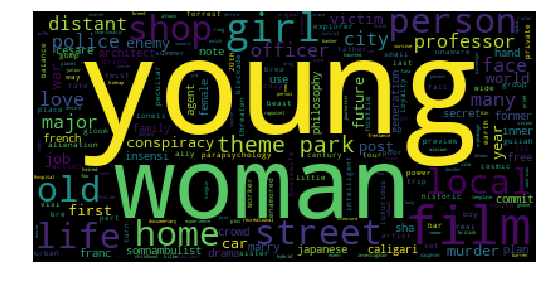

In [21]:
stop_words = set(STOPWORDS)
wordcloud = WordCloud(stopwords = stop_words).generate(str(df['plot_tags']))
plt.figure(figsize=(9,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Tokenization and Sequence Generation

This process involves creating a **unique integer id** for each token or word in the plot tags (As Neural Networks accept only numerical inputs)
    
Both frequently and rarely occuring words are removed from the data for better training purposes as frequent words will not help much in discerning the genres and vice-versa for rare words. <br> **Thresholds** have been set to remove these words from the tokenized dictionary (i.e) Words occuring less than 20 times and words occuring more than 400 times throughout the data are removed.

In [22]:
token = Tokenizer()
token.fit_on_texts(df['plot_tags'].astype('str'))

count_lower_thres = 20
count_upper_thres = 400
rare_words = [w for w,c in token.word_counts.items() if c <= count_lower_thres]
frequent_words = [w for w,c in token.word_counts.items() if c > count_upper_thres]
remove_words = rare_words + frequent_words

for w in remove_words:
    num = token.word_index[w]
    del token.word_index[w]
    del token.word_docs[w]
    del token.word_counts[w]
    del token.index_word[num]
    del token.index_docs[num]
    
df['plot_tag_num_rep']= token.texts_to_sequences(df['plot_tags'].astype('str'))

In [23]:
df['num_rep_length']  = df['plot_tag_num_rep'].apply(lambda x: len(x))
pd.DataFrame(df['num_rep_length'].describe())

,num_rep_length
count,7883.000000
mean,4.397818
std,2.401113
min,0.000000
25%,3.000000
50%,4.000000
75%,6.000000
max,15.000000


### Target Variable Encoding

In [24]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genres_list'])
# transform target variable
y = multilabel_binarizer.transform(df['genres_list'])
multilabel_binarizer.classes_

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Others', 'Romance', 'Sci-Fi', 'Thriller'],
      dtype=object)

In [25]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0])

### Padding and Data Partitioning

In [26]:
x = pad_sequences(df['plot_tag_num_rep'], maxlen=15, padding='post')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=1)

<div class="alert alert-block alert-success">
Padding (Appending 0's) is performed to ensure all the tokenized sequences are of the same length as neural network models demands each observation to be of the same length
</div>

In [27]:
df_padded = pd.DataFrame(pad_sequences(df['plot_tag_num_rep'], maxlen=15, padding='post'))
df_padded.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,232,35,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14,386,401,318,61,0,0,0,0,0,0,0,0,0,0
2,49,72,86,336,184,0,0,0,0,0,0,0,0,0,0
3,372,452,86,59,35,0,0,0,0,0,0,0,0,0,0
4,273,195,486,84,74,214,30,0,0,0,0,0,0,0,0


### Model Implementation - Word Embedding

Embedding neural network has an embedding layer which requires parameter like <br>

- Maximum interger index of the vocabulary (tokenized dictionary) <br>
- Number of dimensions for each word representation 

Each word in the vocabulary is represented by specified n-dimensional dense vectors also known as weights in n-dimensional space (These weights are initially some random real values). The embedding layer maps the vocabulary index input to retrieve its corresponding weights vector whenever that word is sent as an input to the model. <br>*For example, in a five-dimensional space, word "happy" may have it's weight vector as [0.5, 0.22, 0.19, 0, 0.8]* <br><br>
These weight vectors are trained against genres, and during the training the model tries to update the weights in the embedding space in such a way that the weight vectors with the same genre are placed close to each other in that embedding space.
    
**The goal of the model is to train the weights for each word with genres as its target variable** and the resultant weights that we get after the training process are called embedding weights or embeddings.

In [28]:
model = Sequential()
model.add(Embedding(max(token.index_word)+1, 20, input_length=15))    ### Vocab size + 1
model.add(Flatten())
model.add(Dropout(0.65))                 ### To avoid overfitting
model.add(Dense(20, activation='relu'))  ### Having a dense layer is optional
model.add(Dense(18, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy')
print(model.summary())  # summarize the model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 20)            12400     
_________________________________________________________________
flatten_1 (Flatten)          (None, 300)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                6020      
_________________________________________________________________
dense_2 (Dense)              (None, 18)                378       
Total params: 18,798
Trainable params: 18,798
Non-trainable params: 0
_________________________________________________________________
None


<div class="alert alert-block alert-warning">
    <b>Sigmoid</b> - Output layer activation function 
    
<U>Why softmax activation cannot be used?</U><br>
Because with softmax, the output from the neurons are dependent on each other with the probabilities distributed from 0 to 1 across all the output neurons. When dealing with multi-label classification, this will cause a problem as there will be a need to activate more than one neuron for each observation. 

Sigmoid activation helps us solve this problem as its output is independent with each other with probabilites ranging from 0 to 1 for each neuron.
</div>

In [29]:
model.fit(X_train, y_train, epochs=200, class_weight = "balanced", batch_size = 100, verbose=0)

### Model Evaluation and choosing the optimal threshold probability

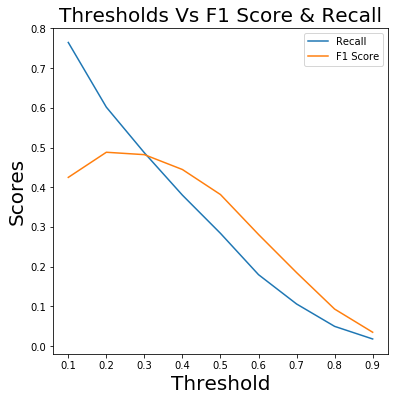

In [30]:
predictions=model.predict(X_test)
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
recall = []
f1 = []
for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    recall.append(recall_score(y_test, pred, average='micro'))
    f1.append(f1_score(y_test, pred, average='micro'))
    
thresholds_df = pd.DataFrame({'Threshold': thresholds, 'Recall': recall, 'F1 Scores': f1})
plt.figure(figsize=(6,6))
plt.plot(thresholds_df['Threshold'],thresholds_df['Recall'])
plt.plot(thresholds_df['Threshold'],thresholds_df['F1 Scores'])
plt.title("Thresholds Vs F1 Score & Recall",fontsize=20)
plt.xlabel("Threshold",fontsize=20)
plt.ylabel("Scores",fontsize=20)
plt.legend(['Recall','F1 Score'])
plt.show()

<div class="alert alert-block alert-success">
    On experimenting with various probability thresholds, we find that the <b>0.2</b> seems to be the optimal thresold as it's gives out the highest F1-Score which will be used further for predicting the genre classes
</div>

### Experimenting with Epochs

In [25]:
epoch_list = [50,100,150,200,300,350,400]
test_scores_list = []
train_scores_list = []
epochs_df = pd.DataFrame()
for epoch in epoch_list:
    model.fit(X_train, y_train, epochs=epoch, class_weight = "balanced", batch_size = 100, verbose=0)
    pred_train=model.predict(X_train)
    pred_test=model.predict(X_test)
    ###Predicting classes for training data with threshold 0.2
    pred_train[pred_train>=0.2]=1
    pred_train[pred_train<0.2]=0
    ###Predicting classes for testing data with threshold 0.2
    pred_test[pred_test>=0.2]=1
    pred_test[pred_test<0.2]=0
    
    train_scores = f1_score(y_train, pred_train, average='micro')
    train_scores_list.append(train_scores)
    test_scores = f1_score(y_test, pred_test, average='micro')
    test_scores_list.append(test_scores)



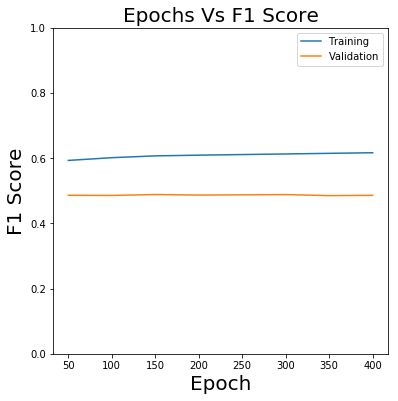

In [26]:
epochs_df = pd.DataFrame({'Epochs': epoch_list, 'Train Scores': train_scores_list, 'Test Scores': test_scores_list})
plt.figure(figsize=(6,6))
plt.plot(epochs_df['Epochs'],epochs_df['Train Scores'])
plt.plot(epochs_df['Epochs'],epochs_df['Test Scores'])
plt.title("Epochs Vs F1 Score",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.ylabel("F1 Score",fontsize=20)
plt.legend(['Training','Validation'])
plt.ylim(0,1)
plt.show()

### Model Evaluation for each genre

Let's see how well the model is predicting the genres using the trained word embeddings

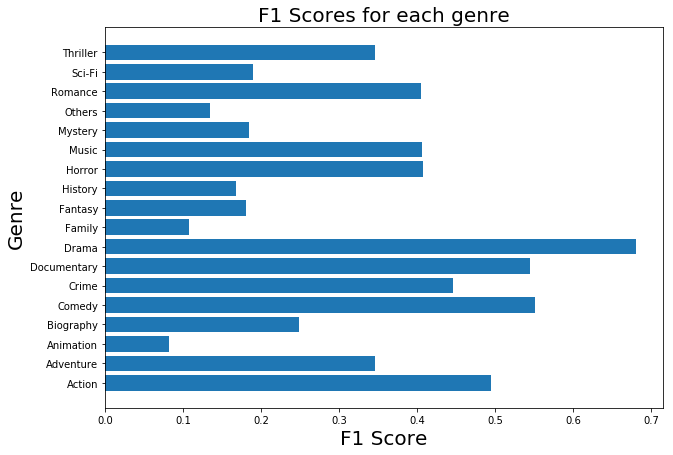

In [41]:
model.fit(X_train, y_train, epochs=500, class_weight = "balanced", batch_size = 100, verbose=0)
pred=model.predict(X_test)
pred[pred>=0.2]=1
pred[pred<0.2]=0

report = classification_report(y_test, pred,target_names=multilabel_binarizer.classes_,digits=2,output_dict=True)
df_report = pd.DataFrame(pd.DataFrame(report).transpose()['f1-score'])
df_report = df_report.head(-4)

plt.figure(figsize=(10,7))
plt.barh(y=df_report.index, width=df_report['f1-score'],align='center')
plt.xlabel("F1 Score",fontsize=20)
plt.ylabel("Genre",fontsize=20)
plt.title("F1 Scores for each genre",fontsize=20)
plt.show()

<div class="alert alert-block alert-success">
The F1-scores seem to be uneven for the genres. This may be due to the presense of high imbalance in the data. Genres like History, Family have very low F1-scores as the number of observations for that genre are relatively low when compared to the other genres
</div>

### Extracting Embedding layer weights

In [43]:
embedding_layer = model.get_layer(name="embedding_1")
weights = embedding_layer.get_weights()[0]

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 20)            12400     
_________________________________________________________________
flatten_1 (Flatten)          (None, 300)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                6020      
_________________________________________________________________
dense_2 (Dense)              (None, 18)                378       
Total params: 18,798
Trainable params: 18,798
Non-trainable params: 0
_________________________________________________________________


### Finding similar words

Similarity between words can be determined using the **dot product** or the **cosine similarity** of the word's weight vectors. Similar words will have this value to be closer to 1.

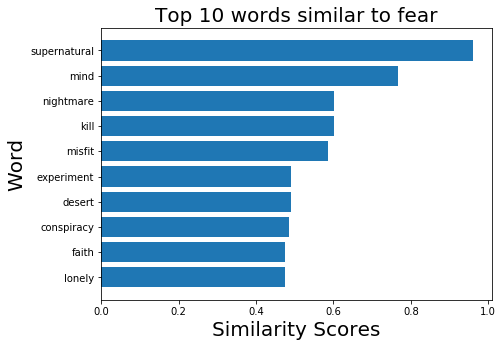

In [56]:
word = "fear"
similar_matrix = np.dot(weights, weights[token.word_index[word]])
similar_scores = np.sort(similar_matrix)[::-1][:10]
index_similar = np.argsort(similar_matrix)[-10:][::-1]

similar_words = []
for i in index_similar:
    similar_words.append(token.index_word[i])
    
plt.figure(figsize=(7,5))
plt.barh(y=similar_words[::-1], width=similar_scores[::-1],align='center')
plt.xlabel("Similarity Scores",fontsize=20)
plt.ylabel("Word",fontsize=20)
plt.title("Top 10 words similar to " +word,fontsize=20)
plt.show()

### Recommendation of movies using word similarities from plots and other features

Word Embeddings, movie genres, movie title names and movie actors are taken into consideration while recommending the movies. 

<u><b>Approach used:</b></u><br>
When a movie title is given as input, its corresponding plot tags, genres and actors are retrieved<br>
Top similar words similar to the plot tags of the input movie are found using the word embeddings created<br>

>The following scores are calculated <br>
- Jaccard Score of "Similar tags found" and the "plot tags" for each movie<br>
- Jaccard Score of "Input movie genre" and the "genres" for each movie <br>
- Movie titles match score to check for sequel or prequel 

Weights are given to each of these scores and the final scores are summed and sorted in descending order to recommend the movies

In [57]:
def recommended_movies(genre,tags,title,actors):
    
    genre = set(genre.split(', '))
    tags = set(tags)
    actors = set(actors.split(', '))
    jaccard_score_plot = 0
    stop = stopwords.words('english')
    title_cleaned = title.split()
    input_movie_cleaned = input_movie.split()
    title_cleaned = " ".join([item for item in title_cleaned if item.lower() not in stop])
    input_movie_cleaned = " ".join([item for item in input_movie_cleaned if item.lower() not in stop])
    
    for i in similar_plots:
        jaccard_score_plot = jaccard_score_plot + len(set(i).intersection(tags)) / len(set(i).union(tags))
    
    jaccard_score_plot = jaccard_score_plot/len(similar_plots)
    jaccard_score_genre = len(input_movie_genre.intersection(genre)) / len(input_movie_genre.union(genre))
    
    if SequenceMatcher(None, input_movie_cleaned,title_cleaned).ratio() > 0.50 and fuzz.token_set_ratio(input_movie_cleaned,title_cleaned) == 100:
        if len(input_movie_actors.intersection(actors)) >= 1 :
            string_match_score = 1
        else:
            string_match_score = 0
    else:
        string_match_score = 0
    
    return (jaccard_score_plot) + (0.1*jaccard_score_genre) + (0.5*string_match_score)
    

In [58]:
input_movie = "Batman v Superman: Dawn of Justice"
df['actors_list'] = df['actors'].apply(lambda x: x.split(', '))
input_movie_plot_tags = df[df['title'] == input_movie]['plot_tag_num_rep'].tolist()
input_movie_genre = set(df[df['title'] == input_movie]['genres_list'].tolist()[0])
input_movie_actors = set(df[df['title'] == input_movie]['actors_list'].tolist()[0])

similar_plots = []
for i in input_movie_plot_tags[0]:
    similar_plots.append(np.argsort(np.dot(weights, weights[i]))[-4:][::-1].tolist())
    
df_similar_movies = pd.DataFrame()
df_similar_movies['title'] = df['title']
df_similar_movies['genre'] = df['genre']

df_similar_movies['jaccard_score']=df.apply(lambda x: recommended_movies(x.genre,x.plot_tag_num_rep,x.title,x.actors),axis=1)
df_similar_movies.sort_values(by="jaccard_score", ascending = False).head(10)

,title,genre,jaccard_score
1722,Batman v Superman: Dawn of Justice,"Action, Adventure, Sci-Fi",0.700000
115,Godzilla,"Action, Adventure, Sci-Fi",0.225000
5142,Transformers: Revenge of the Fallen,"Action, Adventure, Sci-Fi",0.183333
2941,X-Men: The New Mutants,"Action, Sci-Fi",0.166667
905,Guardians of the Galaxy,"Action, Adventure, Sci-Fi",0.162500
4049,Kull the Conqueror,"Fantasy, Action, Adventure",0.150000
28,John Carter,"Action, Adventure, Sci-Fi",0.150000
6860,Spectral,"Action, Mystery, Sci-Fi",0.150000
922,The Great Wall,"Action, Adventure, Fantasy",0.150000
1299,Avengers: Age of Ultron,"Action, Adventure, Sci-Fi",0.150000
